# Assessment
### Urban Simulation
---

Felipe Santos Almeida @ucfnant

SN: 21125032

## Tips

- Use table to summarise information
- Part 1 and Part 2 are equally weighted
- Put the code in the Git Hub
- we need to use the networking from the practical 10

## Doubts

- What is the difference between Betweenness Centrality and Topological Betweenness Centrality?
- What is the purpose to understand diameter measure in a network? How is the best way to understand in London Underground?
- What is the difference between Degree as a global measure and Degree centrality? Is it the same thing?
- If I want to use the clustering as measure, I am not sure how to calculate that into the tube networking and also understand the meaning of this measures into tube networking as a global measure

- Diameter is the longest shortest path


- Can I affirm the clusttering is the oposite of degree( degree most vulnerable -  clustering less vulnerable)? maybe I can make this relationship because clustering is local measure and degree is a global measure


- clustering is a local measure


- degre and degree centrality are the same thing

## Data loading, wrangling and pre-processing


In [198]:
# Packages

import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance
import networkx as nx
from operator import itemgetter

In [199]:
#read in the data using geopandas
stations = gpd.read_file('Data/tfl_stations.json')
lines = gpd.read_file('Data/tfl_lines.json')

In [200]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

In [201]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [202]:
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [203]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [204]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

In [205]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['DLR',
 'Piccadilly',
 'Thameslink 6tph line',
 'Circle',
 'District',
 'Waterloo & City',
 'Jubilee',
 'London Overground',
 'Victoria',
 'Bakerloo',
 'East London',
 'Tramlink',
 'Crossrail 2',
 'Northern',
 'Emirates Air Line',
 'TfL Rail',
 'Metropolitan',
 'Hammersmith & City',
 'Central',
 'Crossrail']

In [206]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [207]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

In [208]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    #nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
   # nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
   # plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
   # nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
   # nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
   # plt.show()
  #  print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


DLR
Piccadilly
Circle
District
Waterloo & City
Jubilee
London Overground
Victoria
Bakerloo
Northern
TfL Rail
Metropolitan
Hammersmith & City
Central


In [209]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,DLR,910GSTFDLL,940GZZDLSHS,"LINESTRING (538524.786 184373.341, 538781.855 ..."
1,DLR,940GZZDLSHS,940GZZDLABR,"LINESTRING (538781.855 183983.337, 539066.263 ..."
2,DLR,940GZZDLABR,940GZZDLWHM,"LINESTRING (539066.263 183400.739, 539160.258 ..."
3,DLR,940GZZDLWHM,940GZZDLSTL,"LINESTRING (539160.258 182933.290, 539147.018 ..."
4,DLR,940GZZDLABR,940GZZDLWHM,"LINESTRING (539066.263 183400.739, 539160.258 ..."


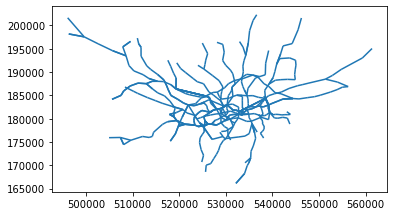

In [210]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

In [211]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    #fig, ax = plt.subplots(figsize = (7,7))
    #fig.suptitle(f'line: {line_name}')
    #ax.set_aspect("equal")
    #ax.axis('off')
    #ax.margins(0.1)
    
    #base = temp_lines.plot(ax=ax, color='grey')
    #temp_stations.plot(ax=base, markersize=20, color='red')
   # plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<AxesSubplot:>

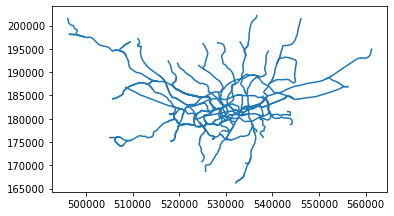

In [212]:
#plot to sanity check
edge_gdf.plot()

In [213]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [214]:
#this is our resulting dataframe
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,DLR,910GSTFDLL,940GZZDLSHS,"LINESTRING (538524.786 184373.341, 538544.907 ...",519.300074
1,DLR,940GZZDLSHS,940GZZDLABR,"LINESTRING (538781.855 183983.337, 538780.690 ...",655.211301
2,DLR,940GZZDLABR,940GZZDLWHM,"LINESTRING (539066.263 183400.739, 539065.339 ...",533.842422
3,DLR,940GZZDLWHM,940GZZDLSTL,"LINESTRING (539160.258 182933.290, 539181.584 ...",863.651663
4,DLR,940GZZDLABR,940GZZDLWHM,"LINESTRING (539066.263 183400.739, 539065.339 ...",533.842422


In [215]:
#let's replace the ids with the actual nane
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [216]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [217]:
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,DLR,Stratford,Stratford High Street,"LINESTRING (538524.786 184373.341, 538544.907 ...",519.300074
1,DLR,Stratford High Street,Abbey Road,"LINESTRING (538781.855 183983.337, 538780.690 ...",655.211301
2,DLR,Abbey Road,West Ham,"LINESTRING (539066.263 183400.739, 539065.339 ...",533.842422
3,DLR,West Ham,Star Lane,"LINESTRING (539160.258 182933.290, 539181.584 ...",863.651663
4,DLR,Abbey Road,West Ham,"LINESTRING (539066.263 183400.739, 539065.339 ...",533.842422


In [218]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'DLR', 'Metropolitan', 'Hammersmith & City', 'Waterloo & City', 'Jubilee', 'Northern', 'London Overground', 'Piccadilly', 'Victoria', 'Central', 'Circle', 'Bakerloo', 'District', 'TfL Rail'}


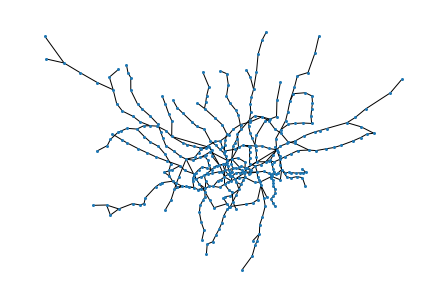

In [219]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [220]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

## Part 1: London’s underground resilience

### 1. Topological network

you will investigate which are the stations that are most critical for the functioning of the underground, and which methodology is more appropriate to finding these stations.

- Lenght

#### 1.1. Centrality measures:

1. Select 3 centrality measures to characterise nodes
    * 3 centralities measures :  degree centrality, closeness centrality and betweenness centrality
2. Give the definition of each of the measures (including their equation)
    - **Degree Centrality:** the number of links associated to a node 
    - **Closeness centrality:** the shortest path to all nodes in the system
    - **Betweenness centrality:** The shortest path passing through a node
3. Compute the measures for your nodes in the network
4. give the results in a table for the first 10 ranked nodes for each of the 3 measures.



* I need to give the context of each meaning in the tube network

##### Degree Centrality

The number of links associated to a node

In [102]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

# To dataframe using the nodes as the index
df_dg = pd.DataFrame(index=G.nodes())
#df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df_dg['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_dg = df_dg.sort_values(["degree"], ascending=False)
df_dg[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
Baker Street,0.0175
King's Cross St. Pancras,0.0175
Canning Town,0.0150
West Ham,0.0150
Green Park,0.0150
Waterloo,0.0150
Earl's Court,0.0150
Oxford Circus,0.0150


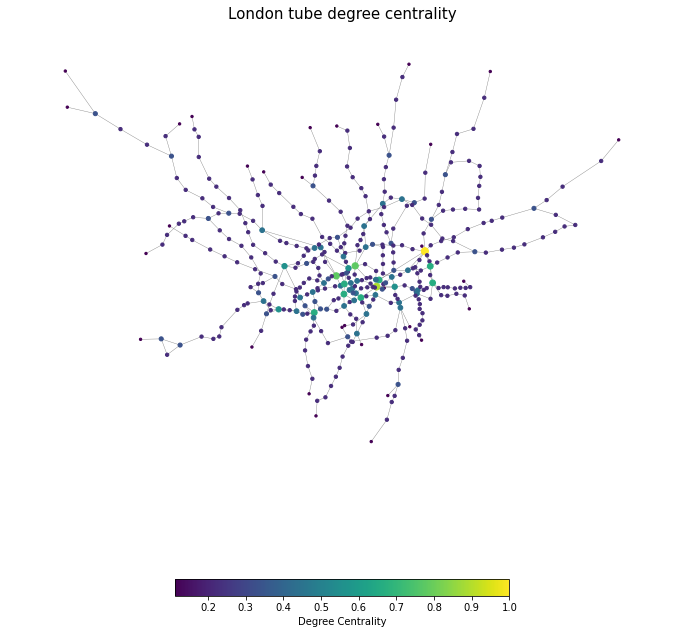

In [103]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]



# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.show()

##### Closeness Centrality

The shortest path to all nodes in the system

In [104]:
#Topological closeness centrality: 
clos_w=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_w,'closeness')

# To ataframe using the nodes as the index
df_cl = pd.DataFrame(index=G.nodes())
#df_cl['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df_cl['closeness'] = pd.Series(nx.get_node_attributes(G, 'closeness'))

df_cl = df_cl.sort_values(["closeness"], ascending=False)
df_cl[0:10]

,closeness
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


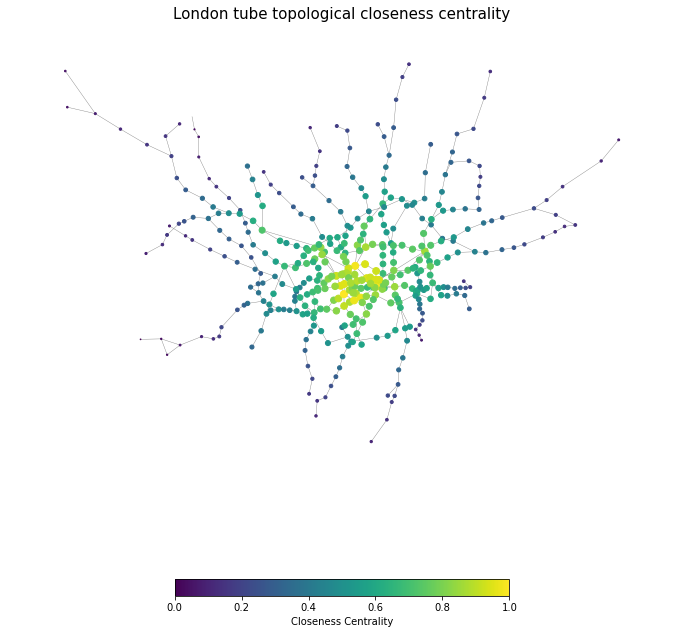

In [105]:
# Lets set color and width of nodes according to the closeness values

clos_w_val=[(i[1]['closeness']) for i in G.nodes(data=True)]

closs_w_color=[(i[1]['closeness']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in G.nodes(data=True)]
closs_w_size=[((i[1]['closeness']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.show()

##### Betweenness Centrality

The way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another. The algorithm calculates shortest paths between all pairs of nodes in a graph. It tell us the importance of a node.

In [106]:
### Topological betweenness centrality:

#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness')

# To dataframe using the nodes as the index
df_bt = pd.DataFrame(index=G.nodes())
# df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df_bt['betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness'))

df_bt= df_bt.sort_values(["betweenness"], ascending=False)
df_bt[0:10]


,betweenness
Stratford,0.297846
Bank and Monument,0.290489
Liverpool Street,0.270807
King's Cross St. Pancras,0.255307
Waterloo,0.243921
Green Park,0.215835
Euston,0.208324
Westminster,0.203335
Baker Street,0.191568
Finchley Road,0.165085


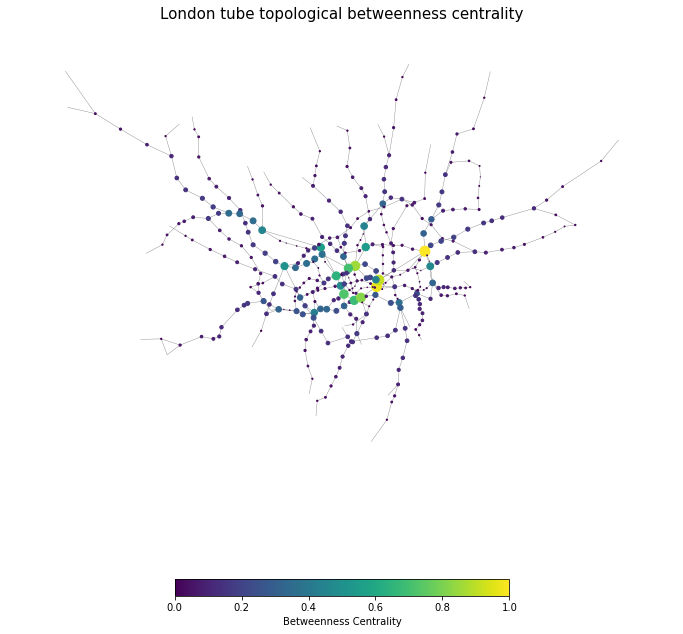

In [107]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.show()

##### Summarizing

In [90]:
df

,degree,closeness,betweenness_t
Harrow & Wealdstone,0.0050,0.056625,0.029624
Kenton,0.0050,0.059907,0.034474
South Kenton,0.0050,0.063573,0.039298
North Wembley,0.0050,0.067693,0.044098
Wembley Central,0.0050,0.072359,0.048872
...,...,...,...
Hounslow East,0.0050,0.054787,0.029624
Osterley,0.0050,0.057854,0.034474
Boston Manor,0.0050,0.061265,0.039298
Northfields,0.0050,0.065083,0.044098


#### 1.2. Impact measures

- Find 2 different measures
- Evaluate the impact of the node removal on the network
- These need to be global measures referring to the whole network and not to specific nodes or links
- Are they just applicable for London Underground or can be applied for other network?


- Distance and Diameter
- 

Use this references below to explain why I choose this variables and also what is the other applications of this measures in other types of network

**Reference**

Jamakovic, A. and Uhlig, S., 2008. On the relationships between topological measures in real-world networks. Networks Heterog. Media, 3(2), pp.345-359.

Kantarci, B. and Labatut, V., 2013, September. Classification of complex networks based on topological properties. In 2013 international conference on Cloud and Green Computing (pp. 297-304). IEEE.

Lin, J. and Ban, Y., 2013. Complex network topology of transportation systems. Transport reviews, 33(6), pp.658-685.

#### 1.3. Node removal: 
Remove at least 10 nodes



- when you reduce the efficient, so as you remove the nodes, the nodes have to reduce the efficient,

- after remove 1, after remove the seconde one and so on...............( IN THE WHOLE SYSTEM)


###### Non-sequential Removal

- Remove 1 node following the rank
- Evaluate the impact using the **two measures**

Using your table in 1.- remove 1 node at a time following the rank in the table, i.e. from the most important one to the 10th most important one. After each removal, evaluate the impact of the removal using your two measures in 2.-, and proceed until you have removed at least 10 nodes.

In [134]:
## Remove the highest node from degree centrality table

# To remove  10 highest values:
# List of nodes:
values_sorted = sorted(deg_london.items(), key=itemgetter(1), reverse=True)
sorted_ten=[e for e,v in values_sorted[:1]]
sorted_ten

#create a new table

# Add the number of nodes removed into the table

# calculate the diameter in put into the table

#calculate connected components and add in the table


# Visualise the final table 


# To remove  10 highest values:
# List of nodes:
values_sorted = sorted(bet_london_t.items(), key=itemgetter(1), reverse=True)
sorted_ten=[e for e,v in values_sorted[:10]]
sorted_ten

In [191]:
# create a copy of the graph object
G_copy = G.copy()

In [192]:
#  We can calculate the degree centrality using networkx function:
deg =nx.degree_centrality(G_copy)
nx.set_node_attributes(G_copy,dict(deg),'degree')

In [193]:
# initialize empty lists to store results
num_nodes_removed_list = []
diameter_list = []
num_connected_components_list = []

In [194]:
# remove n highest node values
nodes_to_remove= sorted(deg.items(), key=itemgetter(1), reverse=True)
sorted_one=[e for e,v in nodes_to_remove[:2]]
G_copy.remove_nodes_from(sorted_one)


In [195]:
# To obtain the largest component as a new graph: 

# Get the list of components:
components = nx.connected_components(G_copy)
# Use the max() command to find the largest one:
largest_component = max(components, key=len)
# Create a "subgraph" of the largest component
Largest_subgraph = G_copy.subgraph(largest_component)

In [196]:
# To coumpute the size of the largest component:
Largest_subgraph.number_of_nodes()

378

In [197]:
# You can compute the diameter of this new graph 
diameter = nx.diameter(Largest_subgraph)
diameter 

49

In [187]:
nx.is_connected(G_copy)


False

In [224]:
# create a copy of the graph object
G_copy = G.copy()

#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G_copy,dict(deg_london),'degree')

# initialize empty lists to store results
num_nodes_removed_list = []
size_largestcomponent_list = []
diameter_largestcomponent_list = []



# loop through values of n from 1 to 10
for n in range(1, 21):
     
    # remove n highest node values
    nodes_to_remove = sorted(deg_london.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:n]]
    G_copy.remove_nodes_from(sorted_one)

    # count the number of nodes removed
    num_nodes_removed = n

    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_copy)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_copy.subgraph(largest_component)
    
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    
    # You can compute the diameter of this new graph 
    diameter_largestcomponent = nx.diameter(Largest_subgraph)
    
    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    size_largestcomponent_list.append(size_largestcomponent)
    diameter_largestcomponent_list.append(diameter_largestcomponent)

# create a pandas DataFrame and add the information as columns
DC_ns = pd.DataFrame()
DC_ns['Node removed'] = num_nodes_removed_list
DC_ns['Size Largest Component'] = size_largestcomponent_list
DC_ns['Diameter Largest Component'] = diameter_largestcomponent_list

DC_ns

,Node removed,Size Largest Component,Diameter Largest Component
0,1,379,49
1,2,378,49
2,3,377,49
3,4,374,49
4,5,371,53
5,6,356,53
6,7,355,53
7,8,354,53
8,9,348,53
9,10,347,53


In [147]:
# create a copy of the graph object
G_copy = G.copy()

In [114]:
#  We can calculate the degree centrality using networkx function:
deg =nx.degree_centrality(G_copy)
nx.set_node_attributes(G_copy,dict(deg),'degree')

In [115]:
# initialize empty lists to store results
num_nodes_removed_list = []
diameter_list = []
num_connected_components_list = []

In [149]:
    # calculate the diameter of the network
    diameter_cp = nx.diameter(G_copy)

In [150]:
 diameter_cp

36

In [117]:
# loop through values of n from 1 to 10
for n in range(1, 11):
    
    # remove n highest node values
    nodes_to_remove = sorted(deg.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in values_sorted[:n]]
    G_copy.remove_nodes_from(sorted_one)

    # count the number of nodes removed
    num_nodes_removed = n

    # calculate the diameter of the network
    diameter = nx.diameter(G_copy)

    # calculate the number of connected components
    #num_connected_components = nx.number_connected_components(G_copy)
    
    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    diameter_list.append(diameter)
   # num_connected_components_list.append(num_connected_components)

NetworkXError: Found infinite path length because the graph is not connected

In [78]:
#Topological closeness centrality: 
clos=nx.closeness_centrality(G_copy)
nx.set_node_attributes(G_copy,clos,'closeness')

# initialize empty lists to store results
num_nodes_removed_list = []
diameter_list = []
num_connected_components_list = []

# loop through values of n from 1 to 10
for n in range(1, 21):
    
    # remove n highest node values
    nodes_to_remove = sorted(clos.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in values_sorted[:n]]
    G_copy.remove_nodes_from(sorted_one)

    # count the number of nodes removed
    num_nodes_removed = n

    # calculate the diameter of the network
    diameter = nx.diameter(G_copy)

    # calculate the number of connected components
    num_connected_components = nx.number_connected_components(G_copy)
    
    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    diameter_list.append(diameter)
    num_connected_components_list.append(num_connected_components)

# create a pandas DataFrame and add the information as columns
CC_ns = pd.DataFrame()
CC_ns['Node removed'] = num_nodes_removed_list
CC_ns['Diameter'] = diameter_list
CC_ns['Connected components'] = num_connected_components_list

CC_ns

NetworkXError: Found infinite path length because the graph is not connected

###### Sequential Removal

Remove the highest ranked node and evaluate the impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes. Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality measure reflects better the importance of a station for the functioning of the underground, which strategy is more effective at studying resilience, and which impact measure is better at assessing the damage after node removal.

### 2.Flows: weighted network

- flows of people

#### 2.1 Centrality measure

#### 2.2 Impact Measures

#### 2.3 Node Removal:

## Part 2: Spatial Interaction models

### 3. Models and calibration

#### 3.1 Introduction (Done*)

III.1. Briefly introduce the spatial interaction models covered in the lectures using equations and
defining the terms, taking particular care in explaining the role of the parameters.

##### Gravity Model(unsconstrained model)

\begin{equation} \tag{2}
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

This model just says that the flows between an origin and destination are proportional to the product of the mass of the origin and destination and inversley proportional to the distance between them.

As origin and destination masses increase, flows increase, but as distance increases, flows decrease, and vice versa.</b>

- Where $T_{ij}$ is the transition or flow, $T$, between origin $i$ (always the rows in a matrix) and destination $j$ (always the columns in a matrix). If you are not overly familiar with matrix notation, the i and j are just generic indexes to allow us to refer to any cell in the matrix more generally.
- $O$ is a vector (a 1 dimensional matrix - or, if you like, a single line of numbers) of origin attributes which relate to the emissiveness of all origins in the dataset, $i$ - in our sample dataset, we have a vector of origin populations (which I have called Oi1_origpop) and a vector of origin average salaries (which I have called Oi2_origsal) in 2001
- $D$ is a vector of desination of attributes relating to the attractivenss of all destinations in the dataset, $j$ - in our sample dataset, we have a vector of destination populations (which I have called Dj1_destpop) and a vector of destination average salaries (which I have called Dj2_destsal) in 2001
- $d$ is a matrix of costs relating to the flows between $i$ and $j$ - in our case the cost is the distance and it is called ‘dist’ in our dataset

##### The Poisson Regression Spatial Interaction Model (unsconstrained model) - calibration

\begin{equation} \tag{6}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

What this model says is that $\lambda_{ij}$ (our independent variable - the estimate of $T_{ij}$) is <i>logarithmically linked </i> to (or modelled by) a linear combination of the logged independent variables in the model. 

Now we have Equation 6 at our disposal, we can use a Poisson regression model to produce estimated of $k$, $\alpha$, $\gamma$ and $\beta$ - or put another way, we can use the rgeression model to calibrate our parameters.


##### Production-constrained Model (Constrained Models)



\begin{equation} \label{eq:1} \tag{1}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

In the production-constrained model, $O_i$ does not have a parameter as it is a known constraint. $A_i$ is known as a <i>balancing factor</i> and is a vector of values which relate to each origin, $i$, which do the equivalent job to $k$ in the unconstrained/total constrained model but ensure that flow estimates from each origin sum to the known totals, $O_i$ rather than just the overall total.

Now at this point, we could calculate all of the $O_i$s and $A_i$s by hand for our sample system and then set about guessing/estimating the parameter values for the rest of the model, but as you might have already suspected from last time, we can use Python and `glm` to make it really easy and do all of that for us -woo hoo!



##### Attraction-Constrained Model (Constrained Models)

- For this model, there is not much information in the practical notebook, do I need to explain it?

\begin{equation} \label{eq:5} \tag{5}
T_ij = D_j B_j O_i^\alpha d_{ij}^{-\beta}
\end{equation}

##### Doubly Constrained Model (Constrained Models)

\begin{equation} \tag{9}
T_{ij} = A_i B_j O_i D_j d_{ij}^{-\beta}
\end{equation}

- We might be interested in understanding the changing patterns of commuting or migration over time. Data from the Census allows us to know an accurate snap-shot of migrating and commuting patterns every 10 years. In these full data matrices, we know both the numbers of commuters/migrants leaving origins and arriving at destinations as well as the interactions between them. If we constrain our model estimates to this known information at origin and destination, we can examine various things, including:
    - The ways that the patterns of commuting/migration differ from the model predictions - where we might get more migrant/commuter flows than we would expect
    - How the model parameters vary over time - for example how does distance / cost of travel affect flows over time? Are people prepared to travel further or less far than before?

(comments)
- in the spatial interaction model the aim is to understand the beta value
- we calculate the balance factors e bacause of that we use all the variables to calibrate
- but in the double contaisnt we only considering the flows but first we  just find the goood beta , and the step number two we focused in the origin in the destinations 
- we use the beta to calculate the new origins in destinations
- beta doesnt change unless the mode of transport not changed

#### 3.2 Calibrate the parameter

Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter for the cost function (usually denoted as ). It is essential that you justify the model selected.

- Here I need to choose a model that I explained below and also justify my choice

### 4. Scenarios

- dont forget to calibrate your model. The number of people do not disappear
- cost functions( research more about this)

- two values of value of the parameter in the cost functions


#### 4.1 Scenario A
- in the case of Cannary Wharf you just reduced the number of jobs, that means you are just reducing the number of Job Attraction to Cannary wahrf, but those people remain in the city, so they just will be redistributed for other area of the city

#### 4.2 Scenario B

#### 4.3 Discussion